<a href="https://colab.research.google.com/github/darknight11345/turtlebot4/blob/main/Text_21_01_25_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pwd


'/content'

In [105]:
!pip install fsspec==2024.10.0


In [67]:
!pip install simpletransformers

  Using cached fsspec-2024.9.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.9.0-py3-none-any.whl (179 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [69]:
import pandas as pd
data = pd.read_csv("ner_dataset_with_head_towards_and_noise_23_01_25.csv",encoding="latin1", delimiter="," )

In [70]:
print("Columns in the CSV:", data.columns)

Columns in the CSV: Index(['Sentence_ID', 'Word', 'POS', 'NER'], dtype='object')


In [74]:
data.columns

Index(['sentence_id', 'words', 'POS', 'labels'], dtype='object')

In [73]:
data.rename(columns={"Sentence_ID":"sentence_id","Word":"words","NER":"labels"}, inplace =True)

In [75]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score

In [83]:
 #Sentence_ID,Sentence,Labels


# Splitting the data into features (X) and labels (y)
X = data[["sentence_id","words"] ] # The sentences
Y = data[["POS","labels"]]    # The
# Split the data (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42) #shuffle=True)

# Now you can use X_train, y_train for training and X_test, y_test for testing


In [79]:
X_train.head(10)

#train_data=pd.DataFrame(X_train)

,sentence_id,words
3031,570,Antibiotics.
7959,1497,to
8511,1600,room
6843,1287,to
4794,898,Paracetamol.
1901,358,with
6178,1160,with
1569,296,523.
4521,848,Penicillin
347,67,Reception


In [84]:
Y_train.head(10)

,POS,labels
3031,PROPN,O
7959,ADP,O
8511,VERB,O
6843,ADP,O
4794,PROPN,O
1901,ADP,O
6178,ADP,O
1569,NUM,I-LOC
4521,PROPN,O
347,PROPN,LOC


In [88]:
# Function to remove periods from words
def remove_periods(data):
    data["words"] = data["words"].str.replace(".", "", regex=False)
    return data

# Remove periods from X_train and X_test datasets
X_train = remove_periods(X_train)
X_test = remove_periods(X_test)

print("Periods removed successfully!")


Periods removed successfully!


In [89]:
#building up train data and test data
train_data = pd.DataFrame({"sentence_id":X_train["sentence_id"],"words":X_train["words"],"labels":Y_train["labels"],"POS":Y_train["POS"]})
test_data = pd.DataFrame({"sentence_id":X_test["sentence_id"],"words":X_test["words"],"labels":Y_test["labels"],"POS":Y_test["POS"]})

In [90]:
test_data.head(10)

,sentence_id,words,labels,POS
3860,724,to,O,ADP
6772,1273,Penicillin,O,PROPN
4299,807,Antibiotics,O,PROPN
8956,1683,station,O,NOUN
4626,867,station,O,NOUN
33,7,to,O,ADP
3333,626,ICU,LOC,PROPN
7143,1343,with,O,ADP
8253,1552,Send,ACTION,VERB
2216,417,597,I-LOC,NUM


In [ ]:
#X= data[["sentence_id","words"]]
#Y =data["labels"]

<ipython-input-87-00a191769821>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


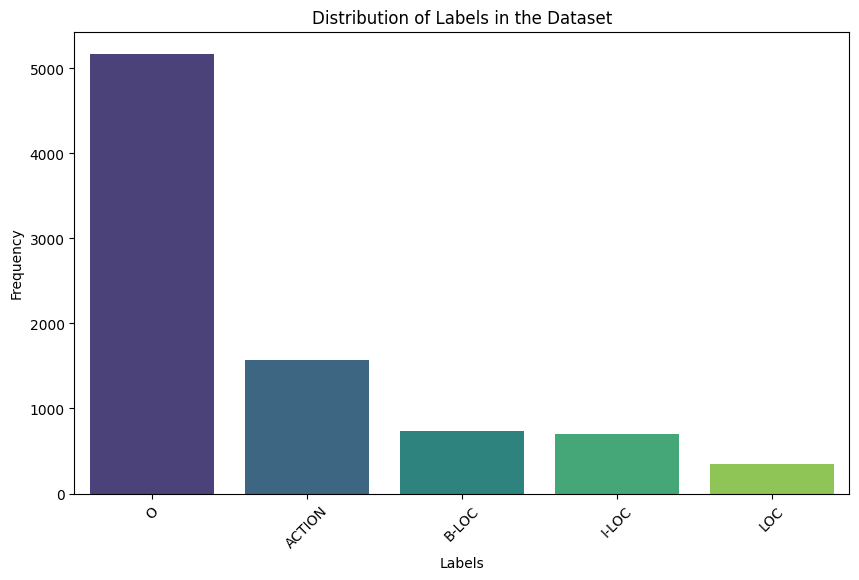

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Assuming your data is in the form of a DataFrame named 'data'
# For example, 'data' has 'Label' column with different labels like 'ACTION', 'O', 'LOCATION'

# Count the frequency of each label
label_counts = train_data['labels'].value_counts()

# Create a bar plot
plt.figure(figsize=(10,6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Distribution of Labels in the Dataset')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


In [16]:
#Model Training
train_data

,sentence_id,words,labels
0,969,Move,ACTION
1,969,to,O
2,969,Room,B-location
3,969,289,I-location
4,969,with,O
...,...,...,...
7979,1127,Navigate,ACTION
7980,1127,to,O
7981,1127,RECEPTION,LOCATION
7982,1127,with,O


In [91]:

!pip install torch  --index-url https://download.pytorch.org/whl/cu122



Looking in indexes: https://download.pytorch.org/whl/cu122


In [92]:
from simpletransformers.ner import NERModel,NERArgs

In [94]:
args = NERArgs()
args.num_train_epochs = 1
args.learning_rate = 1e-4
args.overwrite_output_dir = True
args.train_batch_size = 16  # Reduce batch size
args.eval_batch_size = 16  # Reduce batch size
args.gradient_accumulation_steps = 8  # Compensate for smaller batch size
args.max_seq_length = 64  # Reduce sequence length
args.fp16 = True  # Mixed precision
args.gradient_checkpointing = False  # Disable for stability
args.scheduler = "linear_schedule_with_warmup"
args.warmup_steps = 200  # Reduce warmup steps
args.use_early_stopping = True
args.early_stopping_patience = 3
args.evaluate_during_training = True
args.evaluate_during_training_steps = 5000  # Evaluate less frequently
args.dataloader_num_workers = 2  # Adjust based on CPU resources


In [28]:
#model = NERModel('bert', 'bert-base-uncased',labels=label,args =args, use_cuda=False)

In [95]:
#train_data.shape
#test_data.shape
print(train_data.dtypes)
print(test_data.dtypes)


sentence_id     int64
words          object
labels         object
POS            object
dtype: object
sentence_id     int64
words          object
labels         object
POS            object
dtype: object


In [100]:
#test with sample
# Sample 100 rows from train_data and 20 rows from test_data
train_sample = train_data.sample(n=100)  # Adjust the size as needed
test_sample = test_data.sample(n=60)

print(train_sample.shape)
print(test_sample.shape)


(100, 4)
(60, 4)


<ipython-input-98-ce6f74cfc34c>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


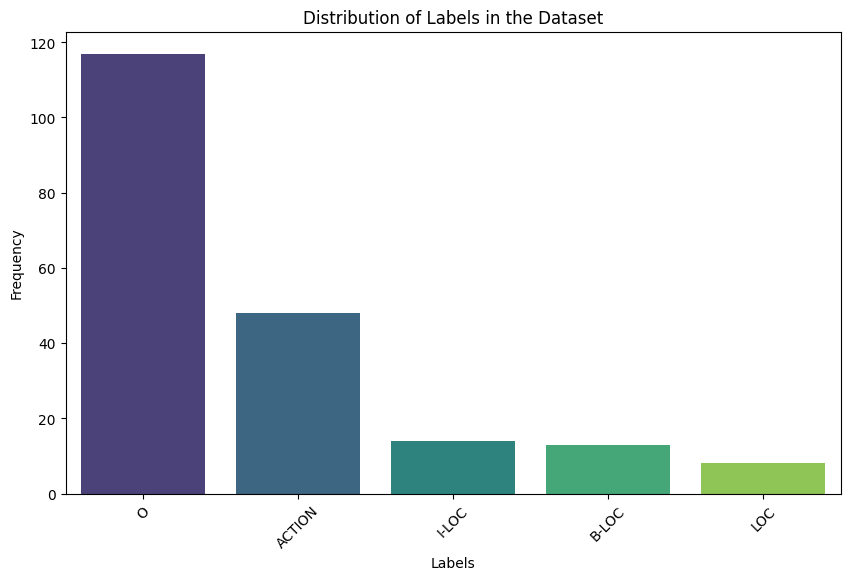

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Assuming your data is in the form of a DataFrame named 'data'
# For example, 'data' has 'Label' column with different labels like 'ACTION', 'O', 'LOCATION'

# Count the frequency of each label
label_counts = train_sample['labels'].value_counts()

# Create a bar plot
plt.figure(figsize=(10,6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Distribution of Labels in the Dataset')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


In [99]:
train_sample

,sentence_id,words,labels,POS
3164,595,Transport,ACTION,PROPN
5959,1118,Penicillin,O,PROPN
9478,1780,Bring,ACTION,VERB
8865,1666,594,I-LOC,NUM
1942,366,with,O,ADP
...,...,...,...,...
4497,843,597,I-LOC,NUM
1855,350,Go,ACTION,VERB
6126,1150,nurse,O,VERB
7256,1364,497,I-LOC,NUM


In [102]:
label = train_sample["labels"].unique().tolist()
label

['ACTION', 'O', 'B-LOC', 'I-LOC', 'LOC']

In [103]:
model = NERModel('bert', 'bert-base-uncased',labels=label,args =args, use_cuda=False)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [104]:
#test with sample
output_dir = "./best_model"



import logging
from simpletransformers.ner import NERModel
from sklearn.metrics import accuracy_score

# Setup logging
log_file = "train_log.txt"
logging.basicConfig(filename=log_file, level=logging.DEBUG, format="%(asctime)s - %(message)s")
logging.info("Training started.")

# Train model function with logging
try:
    output_dir = "./best_model"
    logging.info(f"Training the model with output directory: {output_dir}")

    # Log training data size
    logging.info(f"Training data size: {len(train_sample)}")
  #  logging.info(f"Test data size: {len(test_sample)}")

    # Training the model
    model.train_model(train_sample, eval_data=test_sample, acc=accuracy_score, save_best_model=True, output_dir=output_dir)

    logging.info("Training completed successfully.")

except Exception as e:
    logging.error(f"Error during training: {str(e)}")
    raise  # Re-raise the exception after logging it


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

ERROR:root:Error during training: 'bool' object is not callable


TypeError: 'bool' object is not callable

In [ ]:
import torch

# Save the model's state_dict (weights only)
torch.save(model.model.state_dict(), "model_weights.pth")

In [30]:
result, model_outputs, preds_list = model.eval_model(test_sample)

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ACTION seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: LOCATION seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


In [31]:
result

{'eval_loss': 1.5026317834854126,
 'precision': 0.0,
 'recall': 0.0,
 'f1_score': 0.0}

In [32]:
prediction, model_output = model.predict(["deliver tablets to room 102"])

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

In [33]:
prediction

[[{'deliver': 'O'},
  {'tablets': 'O'},
  {'to': 'O'},
  {'room': 'LOCATION'},
  {'102': 'LOCATION'}]]

In [ ]:
import torch

training_args = torch.load("./outputs/training_args.bin")

# Print or inspect the contents
print(training_args)


NERArgs(adafactor_beta1=None, adafactor_clip_threshold=1.0, adafactor_decay_rate=-0.8, adafactor_eps=(1e-30, 0.001), adafactor_relative_step=True, adafactor_scale_parameter=True, adafactor_warmup_init=True, adam_betas=(0.9, 0.999), adam_epsilon=1e-08, best_model_dir='outputs/best_model', cache_dir='cache_dir/', config={}, cosine_schedule_num_cycles=0.5, custom_layer_parameters=[], custom_parameter_groups=[], dataloader_num_workers=0, do_lower_case=False, dynamic_quantize=False, early_stopping_consider_epochs=False, early_stopping_delta=0, early_stopping_metric='eval_loss', early_stopping_metric_minimize=True, early_stopping_patience=3, encoding=None, eval_batch_size=32, evaluate_during_training=False, evaluate_during_training_silent=True, evaluate_during_training_steps=2000, evaluate_during_training_verbose=False, evaluate_each_epoch=True, fp16=False, gradient_accumulation_steps=4, learning_rate=0.0001, local_rank=-1, logging_steps=50, loss_type=None, loss_args={}, manual_seed=None, ma

<ipython-input-34-91d6a9a137b6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_args = torch.load("./outputs/training_args.bin")
